In [1]:
#Importing Modules
from Funcoes_auxiliares.func_aux import *
import pandas as pd
import numpy as np
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
#from google.colab import drive
from pandas.testing import assert_frame_equal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('base_limpa/base_unificada_limpa.csv')
periodo='2020-2021'
df = df.loc[df['ano_evento'].isin([2020, 2021])]
df['ANO'] = np.where(df['ano_evento']==2020, 0, 1)
# Variável PRM
df['PRM'] = np.where(df['idade_gestacao_faixa'].isin(['entre_37_39', 'entre_40_42']), 0, 1)

# Modelo zero

In [3]:
variaveis =  [  
     'ANO'
    , 'PRM'
    , 'evento_REGIAO'
    , 'idademae_faixa'
    , 'escolaridade_mae'
    ,'tipo_gravidez'
    , 'idade_gestacao_faixa'
    , 'def_sexo'
    , 'peso_faixa'
    , 'FLAG_BASE'
]

df_mod = df[variaveis]

In [4]:
# PRM contagem
NPT = (df_mod['PRM']==1).sum()
NT = (df_mod['PRM']==0).sum()

In [5]:
df_mod = pd.get_dummies(df_mod)

In [6]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5237013 entries, 19956 to 10452700
Data columns (total 31 columns):
 #   Column                             Dtype
---  ------                             -----
 0   ANO                                int32
 1   PRM                                int32
 2   evento_REGIAO_Centro-Oeste         uint8
 3   evento_REGIAO_Nordeste             uint8
 4   evento_REGIAO_Norte                uint8
 5   evento_REGIAO_Sudeste              uint8
 6   evento_REGIAO_Sul                  uint8
 7   idademae_faixa_entre_20_34         uint8
 8   idademae_faixa_entre_35_39         uint8
 9   idademae_faixa_maior_igual_40      uint8
 10  idademae_faixa_menor_igual_19      uint8
 11  escolaridade_mae_Ensino_medio      uint8
 12  escolaridade_mae_Ensino_superior   uint8
 13  escolaridade_mae_Fundamental       uint8
 14  escolaridade_mae_Sem_escolaridade  uint8
 15  tipo_gravidez_Multipla             uint8
 16  tipo_gravidez_Unica                uint8
 17  ida

In [7]:
df_mod.columns

Index(['ANO', 'PRM', 'evento_REGIAO_Centro-Oeste', 'evento_REGIAO_Nordeste',
       'evento_REGIAO_Norte', 'evento_REGIAO_Sudeste', 'evento_REGIAO_Sul',
       'idademae_faixa_entre_20_34', 'idademae_faixa_entre_35_39',
       'idademae_faixa_maior_igual_40', 'idademae_faixa_menor_igual_19',
       'escolaridade_mae_Ensino_medio', 'escolaridade_mae_Ensino_superior',
       'escolaridade_mae_Fundamental', 'escolaridade_mae_Sem_escolaridade',
       'tipo_gravidez_Multipla', 'tipo_gravidez_Unica',
       'idade_gestacao_faixa_entre_22_27', 'idade_gestacao_faixa_entre_28_36',
       'idade_gestacao_faixa_entre_37_39', 'idade_gestacao_faixa_entre_40_42',
       'def_sexo_Feminino', 'def_sexo_Masculino', 'peso_faixa_entre_1500_2499',
       'peso_faixa_entre_2500_3500', 'peso_faixa_entre_3500_3999',
       'peso_faixa_entre_500_1499', 'peso_faixa_maior_igual_4000',
       'peso_faixa_menor_500', 'FLAG_BASE_SIM_DOFET', 'FLAG_BASE_SINASC'],
      dtype='object')

In [8]:
# Modelo
#Defining covariates
var_model=[
     'evento_REGIAO_Centro-Oeste'
    , 'evento_REGIAO_Nordeste'
    , 'evento_REGIAO_Norte'
    #, 'evento_REGIAO_Sudeste'
    , 'evento_REGIAO_Sul'
    #, 'idademae_faixa_entre_20_34'
    , 'idademae_faixa_entre_35_39'
    , 'idademae_faixa_maior_igual_40'
    , 'idademae_faixa_menor_igual_19'
    , 'escolaridade_mae_Ensino_medio'
    #, 'escolaridade_mae_Ensino_superior'
    , 'escolaridade_mae_Fundamental'
    , 'escolaridade_mae_Sem_escolaridade'
    , 'tipo_gravidez_Multipla'
    #, 'tipo_gravidez_Unica'
    , 'idade_gestacao_faixa_entre_22_27'
    , 'idade_gestacao_faixa_entre_28_36'
    #, 'idade_gestacao_faixa_entre_37_39'
    , 'idade_gestacao_faixa_entre_40_42'
    #, 'def_sexo_Feminino'
    , 'def_sexo_Masculino'
    , 'peso_faixa_entre_1500_2499'
    #, 'peso_faixa_entre_2500_3500'
    , 'peso_faixa_entre_3500_3999'
    , 'peso_faixa_entre_500_1499'
    , 'peso_faixa_maior_igual_4000'
    , 'peso_faixa_menor_500'
    , 'FLAG_BASE_SIM_DOFET'
    #, 'FLAG_BASE_SINASC'
]

X = df_mod[var_model].values

## FIRST REGRESSION
y = df_mod[['ANO']].values
clf = LogisticRegression(random_state=0, max_iter=2000).fit(X, y)
df_mod = df_mod.assign(PROPENSITY_SCORE=clf.predict_proba(X)[:, 1])

#USING PROPENSITY SCORE TO SELECT SAMPLES TO SECOND REGRESSION
psw_base=df_mod[((df_mod['PROPENSITY_SCORE']>df_mod['PROPENSITY_SCORE'].quantile(0.1)) &
                 (df_mod['PROPENSITY_SCORE']<df_mod['PROPENSITY_SCORE'].quantile(0.9)))]

#COUNTING
po=len(df_mod)
tpo=len(df_mod[df_mod['ANO']==1])
cpo=len(df_mod[df_mod['ANO']==0])
pa=len(psw_base)
tpa=len(psw_base[psw_base['ANO']==1])
cpa=len(psw_base[psw_base['ANO']==0])

print('----------------------------------------------------------------')
print('USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES')
print('----------------------------------------------------------------')
print('N without missing  :', po)
print('Treated samples    :', tpo,np.round(100*tpo/po,2),'%')
print('Controled samples  :', cpo,np.round(100*cpo/po,2),'%')
print('----------------------------------------------------------------')
print('SELECTED/MATCHET SAMPLES')
print('----------------------------------------------------------------')
print('% Selected         :', np.round(100*pa/po,2),'%')
print('N selected         :', pa)
print('Treated selected   :', tpa,np.round(100*tpa/pa,2),'%')
print('Controled selected :', cpa,np.round(100*cpa/pa,2),'%')
print('----------------------------------------------------------------')
print('')

#PSW weights
w =psw_base['ANO']/psw_base['PROPENSITY_SCORE'] + ((1-psw_base['ANO'])/(1-psw_base['PROPENSITY_SCORE']))


----------------------------------------------------------------
USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES
----------------------------------------------------------------
N without missing  : 5237013
Treated samples    : 2590953 49.47 %
Controled samples  : 2646060 50.53 %
----------------------------------------------------------------
SELECTED/MATCHET SAMPLES
----------------------------------------------------------------
% Selected         : 79.81 %
N selected         : 4179444
Treated selected   : 2069077 49.51 %
Controled selected : 2110367 50.49 %
----------------------------------------------------------------



In [9]:
## SECOND REGRESSION
aux=['ANO']
var_model_2 = [
     'evento_REGIAO_Centro-Oeste'
    , 'evento_REGIAO_Nordeste'
    , 'evento_REGIAO_Norte'
    #, 'evento_REGIAO_Sudeste'
    , 'evento_REGIAO_Sul'
    #, 'idademae_faixa_entre_20_34'
    , 'idademae_faixa_entre_35_39'
    , 'idademae_faixa_maior_igual_40'
    , 'idademae_faixa_menor_igual_19'
    , 'escolaridade_mae_Ensino_medio'
    #, 'escolaridade_mae_Ensino_superior'
    , 'escolaridade_mae_Fundamental'
    , 'escolaridade_mae_Sem_escolaridade'
    , 'tipo_gravidez_Multipla'
    #, 'tipo_gravidez_Unica'
    #, 'idade_gestacao_faixa_entre_22_27'
    #, 'idade_gestacao_faixa_entre_28_36'
    #, 'idade_gestacao_faixa_entre_37_39'
    #, 'idade_gestacao_faixa_entre_40_42'
    #, 'def_sexo_Feminino'
    , 'def_sexo_Masculino'
    , 'peso_faixa_entre_1500_2499'
    #, 'peso_faixa_entre_2500_3500'
    , 'peso_faixa_entre_3500_3999'
    , 'peso_faixa_entre_500_1499'
    , 'peso_faixa_maior_igual_4000'
    , 'peso_faixa_menor_500'
    , 'FLAG_BASE_SIM_DOFET'
    #, 'FLAG_BASE_SINASC'
]

X = psw_base[aux+var_model_2].values
y = psw_base[['PRM']].values

X_ANO = sm.add_constant(X)
clf_ano = sm.Logit(y, X_ANO,weights=w).fit()
aux=['Intercept','ANO']

print('----------------------------------------------------------------')
print('PSW REPORT',periodo)
print('----------------------------------------------------------------')
print(clf_ano.summary(xname=aux+var_model_2))
print('----------------------------------------------------------------')


IC=np.exp(clf_ano.conf_int(0.05))
odds_ratio=pd.DataFrame(
    data = {
        'Var':aux+var_model_2
        , 'Odds_ratio': np.round(np.exp(clf_ano.params),3)
        , 'Odds_Lim_inf': np.round(IC[:,0],3)
        , 'Odds_Lim_Sup': np.round(IC[:,1],3)
        , 'p-values':np.round(clf_ano.pvalues,3)
    }
)
print(tabulate(odds_ratio, headers = 'keys', tablefmt = 'grid'))

Optimization terminated successfully.
         Current function value: 0.252391
         Iterations 8
----------------------------------------------------------------
PSW REPORT 2020-2021
----------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              4179444
Model:                          Logit   Df Residuals:                  4179424
Method:                           MLE   Df Model:                           19
Date:                Wed, 26 Jun 2024   Pseudo R-squ.:                  0.3225
Time:                        21:22:04   Log-Likelihood:            -1.0549e+06
converged:                       True   LL-Null:                   -1.5570e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [10]:
with open(f'{periodo}.txt', 'w') as f:
    f.write('---------------------------------------------------------------- \n')
    f.write('USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES \n')
    f.write('----------------------------------------------------------------\n')
    f.write('N without missing  :' + str(po) +'\n')
    f.write('Treated samples    :' + str([tpo,np.round(100*tpo/po,2)]) + '% \n')
    f.write('Controled samples  :' + str([cpo,np.round(100*cpo/po,2)]) + '% \n')
    f.write('---------------------------------------------------------------- \n')
    f.write('SELECTED/MATCHET SAMPLES\n')
    f.write('---------------------------------------------------------------- \n')
    f.write('% Selected         :' + str(np.round(100*pa/po,2)) + '% \n')
    f.write('N selected         :' + str(pa) + '\n')
    f.write('Treated selected   :' + str([tpa,np.round(100*tpa/pa,2)]) + '% \n')
    f.write('Controled selected :' + str([cpa,np.round(100*cpa/pa,2)]) + '% \n')
    f.write('---------------------------------------------------------------- \n')
    f.write('PSW REPORT - ' + periodo+ '\n')
    f.write(str(clf_ano.summary(xname=aux+var_model_2)))
    f.write('\n')
    f.write(tabulate(odds_ratio, headers = 'keys', tablefmt = 'grid'))

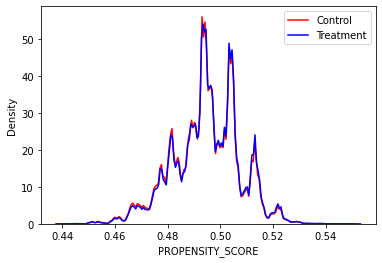

In [11]:
fig = sns.kdeplot(df_mod.query("ANO==0")["PROPENSITY_SCORE"],bw_adjust=.7, shade=False, color="r")
fig = sns.kdeplot(df_mod.query("ANO==1")["PROPENSITY_SCORE"],bw_adjust=.7, shade=False, color="b")
plt.legend(['Control','Treatment'])
plt.savefig('fig1a.png', format='png', dpi=300)
plt.show()

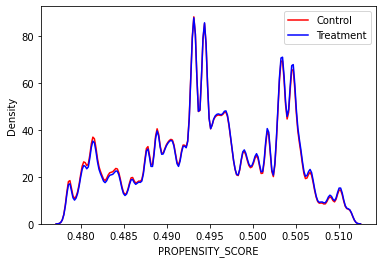

In [12]:
fig = sns.kdeplot(psw_base.query("ANO==0")["PROPENSITY_SCORE"],bw_adjust=0.7, shade=False, color="r")
fig = sns.kdeplot(psw_base.query("ANO==1")["PROPENSITY_SCORE"],bw_adjust=0.7, shade=False, color="b")
plt.legend(['Control','Treatment'])
plt.savefig('fig1b.png', format='png', dpi=300)
plt.show()

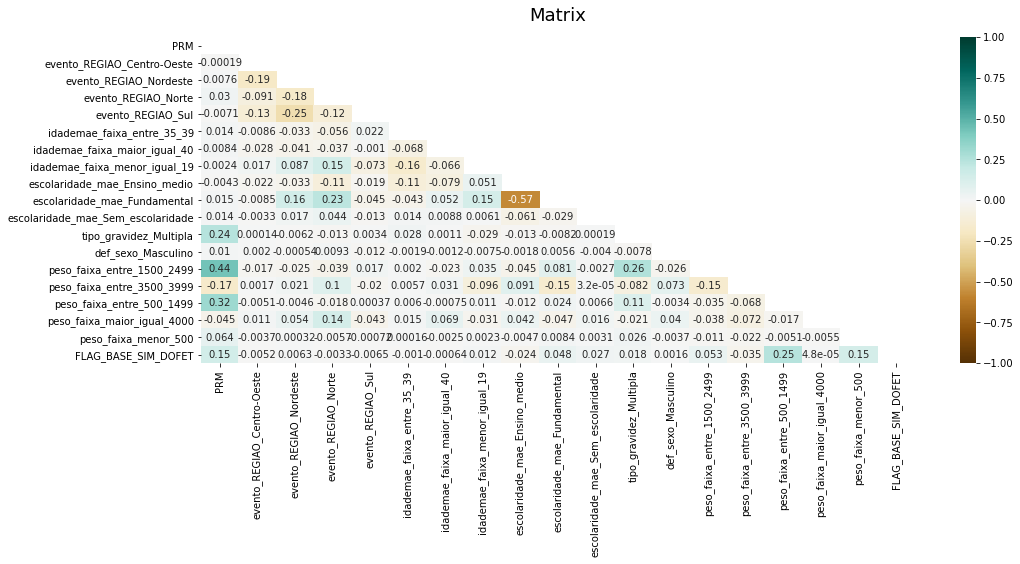

In [13]:
#spearm
var_corr = ['PRM'] + var_model_2


plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True

mask = np.triu(np.ones_like(psw_base[var_corr].corr(method="spearman"), dtype=np.bool))
heatmap = sns.heatmap(psw_base[var_corr].corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Matrix', fontdict={'fontsize':18}, pad=16);

# Modelo 1

In [14]:
variaveis_1 = [  
     'ANO'
    , 'PRM'
    , 'evento_REGIAO'
    , 'idademae_faixa'
    , 'escolaridade_mae'
    ,'tipo_gravidez'
    , 'idade_gestacao_faixa'
    , 'def_sexo'
    , 'peso_faixa'
    , 'FLAG_BASE'
    , 'sum_CENTROBS'
    , 'sum_QTINST34'
    , 'sum_QTINST35'
    , 'sum_QTINST36'
    , 'sum_QTINST37'
    , 'sum_QTLEIT34'
    , 'sum_QTLEIT38'
    , 'sum_QTLEIT39'
    , 'sum_QTLEIT40'
    , 'sum_CENTRNEO'
    , 'TP_UNID_5'
    , 'TP_UNID_7'
    , 'TP_UNID_15'
    , 'TP_UNID_36'
    , 'TP_UNID_61'
    ]
df_mod = df[variaveis_1]

In [15]:
# PRM contagem
NPT = (df_mod['PRM']==1).sum()
NT = (df_mod['PRM']==0).sum()

In [16]:
# Categorizando as novas variáveis. 
df_mod['cat_CENTROBS'] = [1 if i > 0 else 0 for i in df_mod['sum_CENTROBS']]
df_mod['cat_QTINST34'] = [1 if i > 0 else 0 for i in df_mod['sum_QTINST34']]
df_mod['cat_QTINST35'] = [1 if i > 0 else 0 for i in df_mod['sum_QTINST35']]
df_mod['cat_QTINST36'] = [1 if i > 0 else 0 for i in df_mod['sum_QTINST36']]
df_mod['cat_QTINST37'] = [1 if i > 0 else 0 for i in df_mod['sum_QTINST37']]
df_mod['cat_QTLEIT34'] = [1 if i > 0 else 0 for i in df_mod['sum_QTLEIT34']]
df_mod['cat_QTLEIT38'] = [1 if i > 0 else 0 for i in df_mod['sum_QTLEIT38']]
df_mod['cat_QTLEIT39'] = [1 if i > 0 else 0 for i in df_mod['sum_QTLEIT39']]
df_mod['cat_QTLEIT40'] = [1 if i > 0 else 0 for i in df_mod['sum_QTLEIT40']]
df_mod['cat_CENTRNEO'] = [1 if i > 0 else 0 for i in df_mod['sum_CENTRNEO']]
df_mod['cat_TP_UNID_5'] = [1 if i > 0 else 0 for i in df_mod['TP_UNID_5']]
df_mod['cat_TP_UNID_7'] = [1 if i > 0 else 0 for i in df_mod['TP_UNID_7']]
df_mod['cat_TP_UNID_15'] = [1 if i > 0 else 0 for i in df_mod['TP_UNID_15']]
df_mod['cat_TP_UNID_36'] = [1 if i > 0 else 0 for i in df_mod['TP_UNID_36']]
df_mod['cat_TP_UNID_61'] = [1 if i > 0 else 0 for i in df_mod['TP_UNID_61']]

In [17]:
df_mod = df_mod.drop(
    columns=[
        'sum_CENTROBS'
        ,'sum_QTINST34'
        ,'sum_QTINST35'
        ,'sum_QTINST36'
        ,'sum_QTINST37'
        ,'sum_QTLEIT34'
        ,'sum_QTLEIT38'
        ,'sum_QTLEIT39'
        ,'sum_QTLEIT40'
        ,'sum_CENTRNEO'
        ,'TP_UNID_5'
        ,'TP_UNID_7'
        ,'TP_UNID_15'
        ,'TP_UNID_36'
        ,'TP_UNID_61'
    ]
)

In [18]:
df_mod = pd.get_dummies(df_mod)

In [19]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5237013 entries, 19956 to 10452700
Data columns (total 46 columns):
 #   Column                             Dtype
---  ------                             -----
 0   ANO                                int32
 1   PRM                                int32
 2   cat_CENTROBS                       int64
 3   cat_QTINST34                       int64
 4   cat_QTINST35                       int64
 5   cat_QTINST36                       int64
 6   cat_QTINST37                       int64
 7   cat_QTLEIT34                       int64
 8   cat_QTLEIT38                       int64
 9   cat_QTLEIT39                       int64
 10  cat_QTLEIT40                       int64
 11  cat_CENTRNEO                       int64
 12  cat_TP_UNID_5                      int64
 13  cat_TP_UNID_7                      int64
 14  cat_TP_UNID_15                     int64
 15  cat_TP_UNID_36                     int64
 16  cat_TP_UNID_61                     int64
 17  eve

In [20]:
for i in df_mod.columns:
    print(i)

ANO
PRM
cat_CENTROBS
cat_QTINST34
cat_QTINST35
cat_QTINST36
cat_QTINST37
cat_QTLEIT34
cat_QTLEIT38
cat_QTLEIT39
cat_QTLEIT40
cat_CENTRNEO
cat_TP_UNID_5
cat_TP_UNID_7
cat_TP_UNID_15
cat_TP_UNID_36
cat_TP_UNID_61
evento_REGIAO_Centro-Oeste
evento_REGIAO_Nordeste
evento_REGIAO_Norte
evento_REGIAO_Sudeste
evento_REGIAO_Sul
idademae_faixa_entre_20_34
idademae_faixa_entre_35_39
idademae_faixa_maior_igual_40
idademae_faixa_menor_igual_19
escolaridade_mae_Ensino_medio
escolaridade_mae_Ensino_superior
escolaridade_mae_Fundamental
escolaridade_mae_Sem_escolaridade
tipo_gravidez_Multipla
tipo_gravidez_Unica
idade_gestacao_faixa_entre_22_27
idade_gestacao_faixa_entre_28_36
idade_gestacao_faixa_entre_37_39
idade_gestacao_faixa_entre_40_42
def_sexo_Feminino
def_sexo_Masculino
peso_faixa_entre_1500_2499
peso_faixa_entre_2500_3500
peso_faixa_entre_3500_3999
peso_faixa_entre_500_1499
peso_faixa_maior_igual_4000
peso_faixa_menor_500
FLAG_BASE_SIM_DOFET
FLAG_BASE_SINASC


In [21]:
# Modelo
#Defining covariates
var_model=[
     'evento_REGIAO_Centro-Oeste'
    , 'evento_REGIAO_Nordeste'
    , 'evento_REGIAO_Norte'
    #, 'evento_REGIAO_Sudeste'
    , 'evento_REGIAO_Sul'
    #, 'idademae_faixa_entre_20_34'
    , 'idademae_faixa_entre_35_39'
    , 'idademae_faixa_maior_igual_40'
    , 'idademae_faixa_menor_igual_19'
    , 'escolaridade_mae_Ensino_medio'
    #, 'escolaridade_mae_Ensino_superior'
    , 'escolaridade_mae_Fundamental'
    , 'escolaridade_mae_Sem_escolaridade'
    , 'tipo_gravidez_Multipla'
    #, 'tipo_gravidez_Unica'
    , 'idade_gestacao_faixa_entre_22_27'
    , 'idade_gestacao_faixa_entre_28_36'
    #, 'idade_gestacao_faixa_entre_37_39'
    , 'idade_gestacao_faixa_entre_40_42'
    #, 'def_sexo_Feminino'
    , 'def_sexo_Masculino'
    , 'peso_faixa_entre_1500_2499'
    #, 'peso_faixa_entre_2500_3500'
    , 'peso_faixa_entre_3500_3999'
    , 'peso_faixa_entre_500_1499'
    , 'peso_faixa_maior_igual_4000'
    , 'peso_faixa_menor_500'
    , 'FLAG_BASE_SIM_DOFET'
    #, 'FLAG_BASE_SINASC'
    #,'cat_CENTROBS'
    #, 'cat_QTINST34'
    #,'cat_QTINST35'
    #,'cat_QTINST36'
    #, 'cat_QTINST37'
    #, 'cat_QTLEIT34'
    #, 'cat_QTLEIT38'
    #, 'cat_QTLEIT39'
    #, 'cat_QTLEIT40'
    #, 'cat_CENTRNEO'
    #, 'cat_TP_UNID_5'
    #, 'cat_TP_UNID_7'
    , 'cat_TP_UNID_15'
    , 'cat_TP_UNID_36'
]

X = df_mod[var_model].values

## FIRST REGRESSION
y = df_mod[['ANO']].values
clf = LogisticRegression(random_state=0, max_iter=2000).fit(X, y)
df_mod = df_mod.assign(PROPENSITY_SCORE=clf.predict_proba(X)[:, 1])

#USING PROPENSITY SCORE TO SELECT SAMPLES TO SECOND REGRESSION
psw_base=df_mod[((df_mod['PROPENSITY_SCORE']>df_mod['PROPENSITY_SCORE'].quantile(0.1)) &
                 (df_mod['PROPENSITY_SCORE']<df_mod['PROPENSITY_SCORE'].quantile(0.9)))]

#COUNTING
po=len(df_mod)
tpo=len(df_mod[df_mod['ANO']==1])
cpo=len(df_mod[df_mod['ANO']==0])
pa=len(psw_base)
tpa=len(psw_base[psw_base['ANO']==1])
cpa=len(psw_base[psw_base['ANO']==0])

print('----------------------------------------------------------------')
print('USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES')
print('----------------------------------------------------------------')
print('N without missing  :', po)
print('Treated samples    :', tpo,np.round(100*tpo/po,2),'%')
print('Controled samples  :', cpo,np.round(100*cpo/po,2),'%')
print('----------------------------------------------------------------')
print('SELECTED/MATCHET SAMPLES')
print('----------------------------------------------------------------')
print('% Selected         :', np.round(100*pa/po,2),'%')
print('N selected         :', pa)
print('Treated selected   :', tpa,np.round(100*tpa/pa,2),'%')
print('Controled selected :', cpa,np.round(100*cpa/pa,2),'%')
print('----------------------------------------------------------------')
print('')

#PSW weights
w =psw_base['ANO']/psw_base['PROPENSITY_SCORE'] + ((1-psw_base['ANO'])/(1-psw_base['PROPENSITY_SCORE']))

----------------------------------------------------------------
USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES
----------------------------------------------------------------
N without missing  : 5237013
Treated samples    : 2590953 49.47 %
Controled samples  : 2646060 50.53 %
----------------------------------------------------------------
SELECTED/MATCHET SAMPLES
----------------------------------------------------------------
% Selected         : 79.5 %
N selected         : 4163581
Treated selected   : 2058249 49.43 %
Controled selected : 2105332 50.57 %
----------------------------------------------------------------



In [22]:
## SECOND REGRESSION
aux=['ANO']
var_model_2 = [
     'evento_REGIAO_Centro-Oeste'
    , 'evento_REGIAO_Nordeste'
    , 'evento_REGIAO_Norte'
    #, 'evento_REGIAO_Sudeste'
    , 'evento_REGIAO_Sul'
    #, 'idademae_faixa_entre_20_34'
    , 'idademae_faixa_entre_35_39'
    , 'idademae_faixa_maior_igual_40'
    , 'idademae_faixa_menor_igual_19'
    , 'escolaridade_mae_Ensino_medio'
    #, 'escolaridade_mae_Ensino_superior'
    , 'escolaridade_mae_Fundamental'
    , 'escolaridade_mae_Sem_escolaridade'
    , 'tipo_gravidez_Multipla'
    #, 'tipo_gravidez_Unica'
    #, 'idade_gestacao_faixa_entre_22_27'
    #, 'idade_gestacao_faixa_entre_28_36'
    #, 'idade_gestacao_faixa_entre_37_39'
    #, 'idade_gestacao_faixa_entre_40_42'
    #, 'def_sexo_Feminino'
    , 'def_sexo_Masculino'
    , 'peso_faixa_entre_1500_2499'
    #, 'peso_faixa_entre_2500_3500'
    , 'peso_faixa_entre_3500_3999'
    , 'peso_faixa_entre_500_1499'
    , 'peso_faixa_maior_igual_4000'
    , 'peso_faixa_menor_500'
    , 'FLAG_BASE_SIM_DOFET'
    #, 'FLAG_BASE_SINASC'
    #,'cat_CENTROBS'
    #,'cat_QTINST34'
    # 'cat_QTINST35'
    #,'cat_QTINST36'
    #, 'cat_QTINST37'
    #, 'cat_QTLEIT34'
    #, 'cat_QTLEIT38'
    #, 'cat_QTLEIT39'
    #, 'cat_QTLEIT40'
    #, 'cat_CENTRNEO'
    #, 'cat_TP_UNID_5'
    #, 'cat_TP_UNID_7'
    , 'cat_TP_UNID_15'
    , 'cat_TP_UNID_36'
]

X = psw_base[aux+var_model_2].values
y = psw_base[['PRM']].values

X_ANO = sm.add_constant(X)
clf_ano = sm.Logit(y, X_ANO,weights=w).fit()
aux=['Intercept','ANO']

print('----------------------------------------------------------------')
print('PSW REPORT',periodo)
print('----------------------------------------------------------------')
print(clf_ano.summary(xname=aux+var_model_2))
print('----------------------------------------------------------------')


IC=np.exp(clf_ano.conf_int(0.05))
odds_ratio=pd.DataFrame(
    data = {
        'Var':aux+var_model_2
        , 'Odds_ratio': np.round(np.exp(clf_ano.params),3)
        , 'Odds_Lim_inf': np.round(IC[:,0],3)
        , 'Odds_Lim_Sup': np.round(IC[:,1],3)
        , 'p-values':np.round(clf_ano.pvalues,3)
    }
)
print(tabulate(odds_ratio, headers = 'keys', tablefmt = 'grid'))

Optimization terminated successfully.
         Current function value: 0.257267
         Iterations 8
----------------------------------------------------------------
PSW REPORT 2020-2021
----------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              4163581
Model:                          Logit   Df Residuals:                  4163559
Method:                           MLE   Df Model:                           21
Date:                Wed, 26 Jun 2024   Pseudo R-squ.:                  0.2950
Time:                        21:25:27   Log-Likelihood:            -1.0712e+06
converged:                       True   LL-Null:                   -1.5194e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------

In [23]:
with open(f'{periodo}.txt', 'w') as f:
    f.write('---------------------------------------------------------------- \n')
    f.write('USING PROPENSITY SCORE TO SELECT/MATCH SAMPLES \n')
    f.write('----------------------------------------------------------------\n')
    f.write('N without missing  :' + str(po) +'\n')
    f.write('Treated samples    :' + str([tpo,np.round(100*tpo/po,2)]) + '% \n')
    f.write('Controled samples  :' + str([cpo,np.round(100*cpo/po,2)]) + '% \n')
    f.write('---------------------------------------------------------------- \n')
    f.write('SELECTED/MATCHET SAMPLES\n')
    f.write('---------------------------------------------------------------- \n')
    f.write('% Selected         :' + str(np.round(100*pa/po,2)) + '% \n')
    f.write('N selected         :' + str(pa) + '\n')
    f.write('Treated selected   :' + str([tpa,np.round(100*tpa/pa,2)]) + '% \n')
    f.write('Controled selected :' + str([cpa,np.round(100*cpa/pa,2)]) + '% \n')
    f.write('---------------------------------------------------------------- \n')
    f.write('PSW REPORT - ' + periodo+ '\n')
    f.write(str(clf_ano.summary(xname=aux+var_model_2)))
    f.write('\n')
    f.write(tabulate(odds_ratio, headers = 'keys', tablefmt = 'grid'))

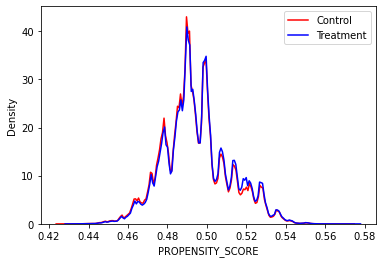

In [24]:
fig = sns.kdeplot(df_mod.query("ANO==0")["PROPENSITY_SCORE"],bw_adjust=.7, shade=False, color="r")
fig = sns.kdeplot(df_mod.query("ANO==1")["PROPENSITY_SCORE"],bw_adjust=.7, shade=False, color="b")
plt.legend(['Control','Treatment'])
plt.savefig('fig1a.png', format='png', dpi=300)
plt.show()

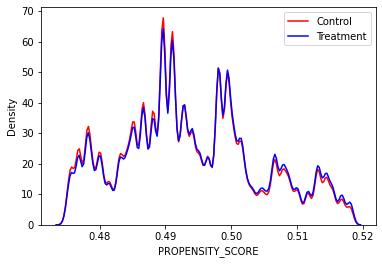

In [25]:
fig = sns.kdeplot(psw_base.query("ANO==0")["PROPENSITY_SCORE"],bw_adjust=0.7, shade=False, color="r")
fig = sns.kdeplot(psw_base.query("ANO==1")["PROPENSITY_SCORE"],bw_adjust=0.7, shade=False, color="b")
plt.legend(['Control','Treatment'])
plt.savefig('fig1b.png', format='png', dpi=300)
plt.show()

In [ ]:
#spearm
var_corr = ['PRM'] + var_model_2

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True

mask = np.triu(np.ones_like(psw_base[var_corr].corr(method="spearman"), dtype=np.bool))
heatmap = sns.heatmap(psw_base[var_corr].corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Matrix', fontdict={'fontsize':18}, pad=16);